<a href="https://colab.research.google.com/github/chaerui7967/stock_predict_news_and_youtube/blob/master/%EC%82%BC%EC%84%B1%EC%A0%84%EC%9E%90_%EC%A3%BC%EC%8B%9D_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 삼성전자 주식 예측

### 데이터 불러오기

In [1]:
# 필요 모듈 설치
!pip install finance-datareader
!pip install opendartreader
!pip install --upgrade opendartreader

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# 주식가격 로딩
import FinanceDataReader as fdr

# 재무재표 로딩
import OpenDartReader

## EDA

### 주식 EDA

In [3]:
import datetime

In [4]:
start_date = '20180101'
end_date = datetime.datetime.now().strftime("%Y%m%d")
sample_code = '005930'
stock = fdr.DataReader( sample_code, start = start_date, end = end_date )
stock

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2018-01-02,51380,51400,50780,51020,169485,0.001177
2018-01-03,52540,52560,51420,51620,200270,0.011760
2018-01-04,52120,52180,50640,51080,233909,-0.010461
2018-01-05,51300,52120,51200,52120,189623,0.020360
2018-01-08,52400,52520,51500,52020,167673,-0.001919
...,...,...,...,...,...,...
2021-09-03,76400,76700,76000,76600,12096419,0.007895
2021-09-06,76800,77600,76600,77300,12861180,0.009138
2021-09-07,77100,77100,75900,76100,13239401,-0.015524


Text(0, 0.5, 'price')

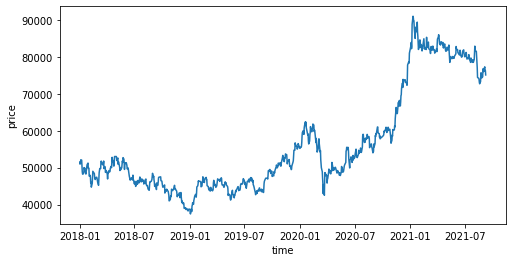

In [5]:
plt.figure(figsize=(8, 4))
sns.lineplot(y=stock['Close'], x=stock.index)
plt.xlabel('time')
plt.ylabel('price')

### 거래량과 종가 간의 관계 확인

In [6]:
stock.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2018-01-02,51380,51400,50780,51020,169485,0.001177
2018-01-03,52540,52560,51420,51620,200270,0.011760
2018-01-04,52120,52180,50640,51080,233909,-0.010461
2018-01-05,51300,52120,51200,52120,189623,0.020360
2018-01-08,52400,52520,51500,52020,167673,-0.001919


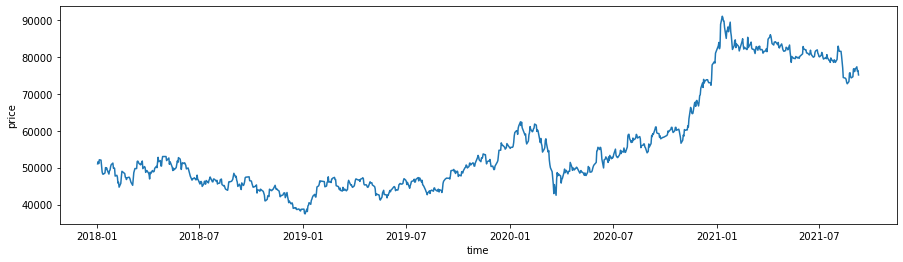

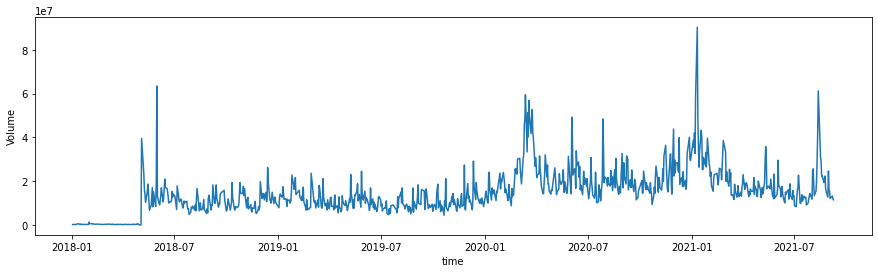

In [7]:
plt.figure(figsize=(15, 4))
sns.lineplot(y=stock['Close'], x=stock.index) # 시간에 따른 종가 변화
plt.xlabel('time')
plt.ylabel('price')

plt.figure(figsize=(15, 4))
sns.lineplot(y=stock['Volume'], x=stock.index)  # 시간에 따른 거래량 변화
plt.xlabel('time')
plt.ylabel('Volume')
plt.show()

In [8]:
from sklearn.preprocessing import MinMaxScaler

df = pd.DataFrame(MinMaxScaler().fit_transform(stock))
df.columns = list(stock.columns)

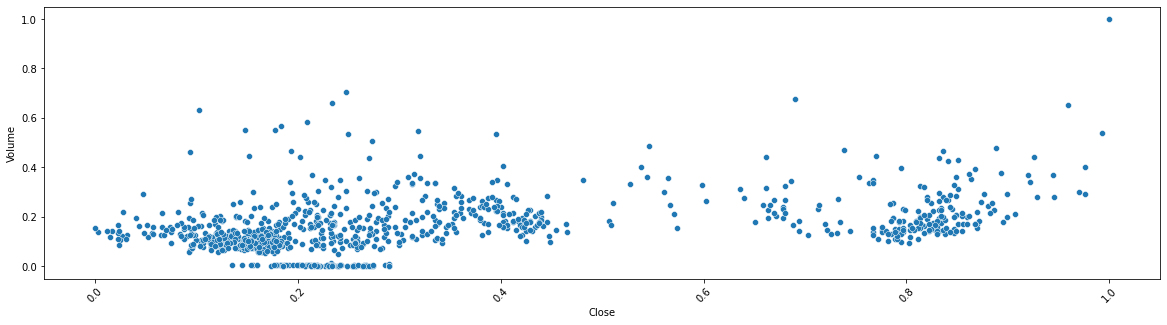

In [9]:
plt.figure(figsize=(20, 5))
sns.scatterplot(data=df, x='Close', y='Volume') # 상관성은 거의 없어보임..
plt.xticks(rotation=45)
plt.show()

#### 2018년 거래량 증폭
- https://www.yna.co.kr/view/AKR20180504037752008
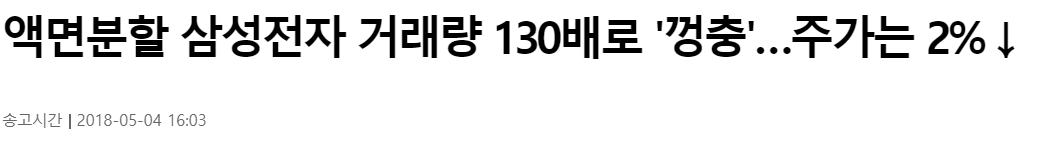

In [10]:
# 2018이후 거래량이 증가 
stock[stock.index >= '2018-04-25'].head(10)

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2018-04-25,49220,50500,49220,50400,332292,-0.001189
2018-04-26,50420,52160,50400,52140,360931,0.034524
2018-04-27,53380,53639,52440,53000,606216,0.016494
2018-04-30,0,0,0,53000,0,0.000000
2018-05-02,0,0,0,53000,0,0.000000
2018-05-03,0,0,0,53000,0,0.000000
2018-05-04,53000,53900,51800,51900,39565391,-0.020755
2018-05-08,52600,53200,51900,52600,23104720,0.013487
2018-05-09,52600,52800,50900,50900,16128305,-0.032319


 - 거래량의 차이가 있어 분석에 영향을 줄수 있으므로 분석기간을 2018년 5월 4일 이후 데이터를 사용하여 분석을 진행

 - 두 연속형변수간의 상관성을 파악하기 위해서 피어슨 상관계수를 활용

In [11]:
stock_re = stock[stock.index >= '2018-05-04']

In [12]:
stock_re.corr()['Close'].sort_values(ascending = False)[1:]

High      0.999289
Low       0.999217
Open      0.998422
Volume    0.366452
Change    0.042738
Name: Close, dtype: float64

- Close - Volume 의 피어슨 상관계수는 0.374137 로 약한 양의 상관성이 있는 것으로 보인다. 하지만 이것만으로 Close를 예측하는 것은 무리가 있어 보인다.

#### 주식 가격의 변동율을 통해서 가격등락 예측
- 시계열 정상성을 성립을 위해서

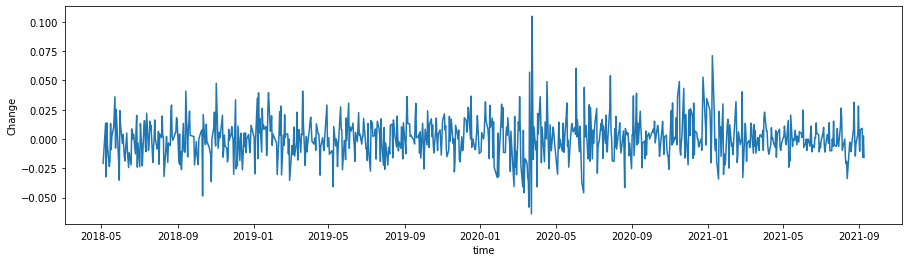

In [13]:
plt.figure(figsize=(15, 4))
sns.lineplot(y=stock_re['Change'], x=stock_re.index)
plt.xlabel('time')
plt.ylabel('Change')
plt.show()

In [14]:
import numpy as np

In [15]:
stock_re['Change'].quantile(0.75)

0.009964037903608336

In [16]:
stock_re['UD'] = np.where(stock_re['Change'] > stock_re['Change'].quantile(0.75), 1, np.where(stock_re['Change'] < stock_re['Change'].quantile(0.25), -1, 0))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [17]:
stock_re.UD.value_counts()

 0    413
 1    207
-1    207
Name: UD, dtype: int64

In [18]:
stock_re.head()

,Open,High,Low,Close,Volume,Change,UD
Date,,,,,,,
2018-05-04,53000,53900,51800,51900,39565391,-0.020755,-1
2018-05-08,52600,53200,51900,52600,23104720,0.013487,1
2018-05-09,52600,52800,50900,50900,16128305,-0.032319,-1
2018-05-10,51700,51700,50600,51600,13905263,0.013752,1
2018-05-11,52000,52200,51200,51300,10314997,-0.005814,0


## LSTM - Classification

### 데이터 전처리

In [19]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Change', 'UD']
# 스케일 후 columns
scaled = scaler.fit_transform(stock_re[scale_cols])
scaled

array([[0.29422895, 0.27533784, 0.28395062, ..., 0.40930157, 0.25579124,
        0.        ],
       [0.28666036, 0.26351351, 0.28584995, ..., 0.21767481, 0.45890951,
        1.        ],
       [0.28666036, 0.25675676, 0.2668566 , ..., 0.13645893, 0.18719175,
        0.        ],
       ...,
       [0.75023652, 0.66722973, 0.74169041, ..., 0.10282778, 0.28681927,
        0.        ],
       [0.72942289, 0.65540541, 0.7359924 , ..., 0.08604943, 0.39449385,
        0.5       ],
       [0.73699149, 0.65878378, 0.72649573, ..., 0.08190225, 0.28561239,
        0.        ]])

In [20]:
df = pd.DataFrame(scaled, columns=scale_cols)

In [21]:
df.head()

,Open,High,Low,Close,Volume,Change,UD
0,0.294229,0.275338,0.283951,0.269841,0.409302,0.255791,0.0
1,0.286660,0.263514,0.285850,0.282913,0.217675,0.458910,1.0
2,0.286660,0.256757,0.266857,0.251167,0.136459,0.187192,0.0
3,0.269631,0.238176,0.261159,0.264239,0.110579,0.460481,1.0
4,0.275307,0.246622,0.272555,0.258637,0.068783,0.344417,0.5


### train / test 분할

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('UD', 1), df['UD'], test_size=0.2, random_state=0, shuffle=False)

In [24]:
x_train.shape, y_train.shape

((661, 6), (661,))

In [25]:
x_test.shape, y_test.shape

((166, 6), (166,))

In [26]:
import tensorflow as tf  

In [27]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

WINDOW_SIZE=20
BATCH_SIZE=32

In [28]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [29]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, feature갯수): (32, 1)


### 모델

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation='softmax'),
    Dense(1),
])

# model.add(LSTM(64,
#                input_shape = (None, 1),
#                return_sequences= True))
# model.add(LSTM(64,
#                input_shape = (None, 1),
#                return_sequences = False))
# model.add(Dense(32, activation = 'tanh'))
# model.add(Dense(1, activation = 'softmax'))


In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 20, 32)            192       
_________________________________________________________________
lstm (LSTM)                  (None, 16)                3136      
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 3,617
Trainable params: 3,617
Non-trainable params: 0
_________________________________________________________________


In [32]:
optimizer = Adam(0.0005)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [33]:
# earlystopping은 10번 epoch동안 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor = 'val_accuracy',
                              mode = 'max',
                              patience = 50,
                              verbose = 1)
# 체크포인터도 생성합니다.
checkpoint = ModelCheckpoint('best.h5',
                             monitor='val_accuracy',
                             mode = 'max',
                             save_best_only = True, 
                             verbose=1)

In [34]:
history = model.fit(train_data,
                    epochs=1000, 
                    batch_size = 1,
                    validation_data=(test_data), 
                    callbacks=[checkpoint, earlystopping],
                    verbose=1)

Epoch 1/1000
21/21 [==============================] - 4s 40ms/step - loss: 6.0535e-08 - accuracy: 0.2543 - val_loss: 5.5930e-08 - val_accuracy: 0.1986

Epoch 00001: val_accuracy improved from -inf to 0.19863, saving model to best.h5
Epoch 2/1000
21/21 [==============================] - 0s 12ms/step - loss: 6.0535e-08 - accuracy: 0.2543 - val_loss: 5.5930e-08 - val_accuracy: 0.1986

Epoch 00002: val_accuracy did not improve from 0.19863
Epoch 3/1000
21/21 [==============================] - 0s 12ms/step - loss: 6.0535e-08 - accuracy: 0.2543 - val_loss: 5.5930e-08 - val_accuracy: 0.1986

Epoch 00003: val_accuracy did not improve from 0.19863
Epoch 4/1000
21/21 [==============================] - 0s 12ms/step - loss: 6.0535e-08 - accuracy: 0.2543 - val_loss: 5.5930e-08 - val_accuracy: 0.1986

Epoch 00004: val_accuracy did not improve from 0.19863
Epoch 5/1000
21/21 [==============================] - 0s 12ms/step - loss: 6.0535e-08 - accuracy: 0.2543 - val_loss: 5.5930e-08 - val_accuracy: 0.

In [35]:
model.load_weights('best.h5')

In [36]:
pred = model.predict(test_data)

In [37]:
print(test_data.take(1))

<TakeDataset shapes: ((None, None, 1), (None, 1)), types: (tf.float64, tf.float64)>


In [38]:
pred.shape

(146, 1)

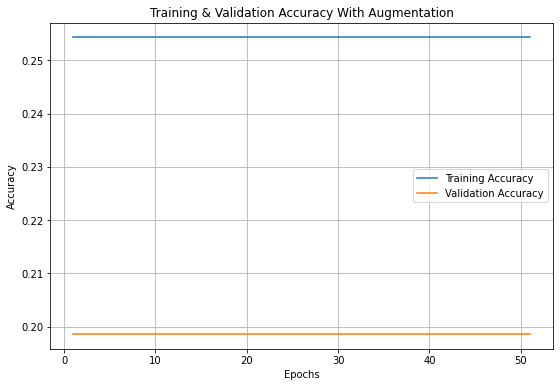

In [39]:
epochs = range(1, len(history.history['loss']) + 1)
plt.figure(figsize = (9, 6))
plt.plot(epochs, history.history['accuracy'])
plt.plot(epochs, history.history['val_accuracy'])
plt.title('Training & Validation Accuracy With Augmentation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.grid()
plt.show()

## 종가 예측
- 데이터의 정상성 가정..

In [40]:
df.head()

,Open,High,Low,Close,Volume,Change,UD
0,0.294229,0.275338,0.283951,0.269841,0.409302,0.255791,0.0
1,0.286660,0.263514,0.285850,0.282913,0.217675,0.458910,1.0
2,0.286660,0.256757,0.266857,0.251167,0.136459,0.187192,0.0
3,0.269631,0.238176,0.261159,0.264239,0.110579,0.460481,1.0
4,0.275307,0.246622,0.272555,0.258637,0.068783,0.344417,0.5


In [41]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(['Close','UD'], 1), df['Close'], test_size=0.2, random_state=0, shuffle=False)

In [42]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

WINDOW_SIZE=20
BATCH_SIZE=32
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

### 모델

In [43]:
model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [44]:
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [45]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [46]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
21/21 [==============================] - 3s 38ms/step - loss: 0.0391 - mse: 0.0781 - val_loss: 0.2621 - val_mse: 0.5242

Epoch 00001: val_loss improved from inf to 0.26212, saving model to tmp/ckeckpointer.ckpt
Epoch 2/50
21/21 [==============================] - 0s 13ms/step - loss: 0.0171 - mse: 0.0343 - val_loss: 0.0771 - val_mse: 0.1542

Epoch 00002: val_loss improved from 0.26212 to 0.07711, saving model to tmp/ckeckpointer.ckpt
Epoch 3/50
21/21 [==============================] - 0s 11ms/step - loss: 0.0055 - mse: 0.0109 - val_loss: 0.0370 - val_mse: 0.0740

Epoch 00003: val_loss improved from 0.07711 to 0.03700, saving model to tmp/ckeckpointer.ckpt
Epoch 4/50
21/21 [==============================] - 0s 12ms/step - loss: 0.0036 - mse: 0.0071 - val_loss: 0.0171 - val_mse: 0.0343

Epoch 00004: val_loss improved from 0.03700 to 0.01714, saving model to tmp/ckeckpointer.ckpt
Epoch 5/50
21/21 [==============================] - 0s 12ms/step - loss: 0.0020 - mse: 0.0041 - val_

In [47]:
model.load_weights(filename)

In [48]:
pred = model.predict(test_data)

In [49]:
pred.shape

(146, 1)

In [50]:
pd.DataFrame(pred)

,0
0,0.868998
1,0.865009
2,0.862531
3,0.860592
4,0.858932
...,...
141,0.740325
142,0.740185
143,0.741527
144,0.742065


### 결과 그래프

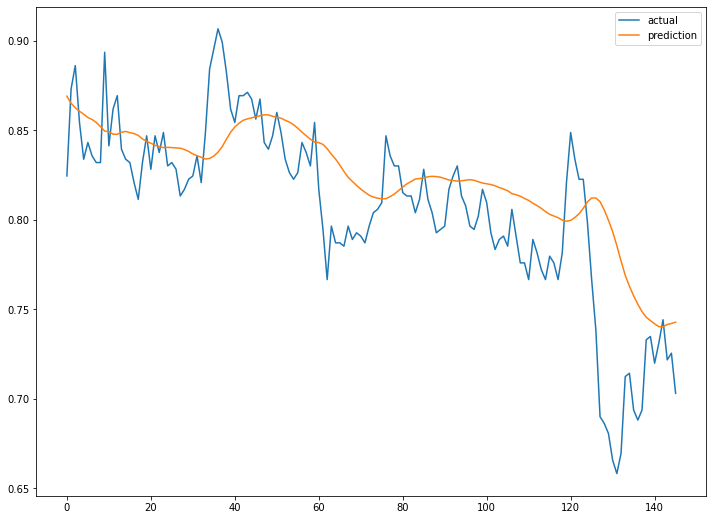

In [51]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

## 재무정보 추가

### 재무정보

- PER : 주가를 1주당 순이익(EPS)로 나눈 값
- PBR : 주가를 1주당 순자산가치로 나눈 값
- ROE : 당기순이익을 순자산(자기자본)으로 나눈 값
- ROA : 당기순이익을 자산총액으로 나눈 값

- 주가, 당기 순이익, 총발행 주식수, 자복, 부채

In [52]:
api_key = '9b9157d4313a84f3141d73f879c5d239d49bb0ce'
dart = OpenDartReader(api_key)

#### 자본, 자산, 당기순이익 조회
corp: 종목코드, bsns_year: 사업연도, reprt_code: 보고서코드
- (1분기보고서 : 11013, 반기보고서 : 11012, 3분기보고서 : 11014, 사업보고서 : 11011)

자본과 자산(자본+부채)은 재무상태표(sj_vis='BIS'), 당기순이익은 포괄손익계산서(sj_div='CIS')에서 확인할 수 있다.

In [53]:
fs_2019 = dart.finstate_all(corp='005930', bsns_year='2019', fs_div='CFS', reprt_code=11011) 
fs_2020_3Q = dart.finstate_all(corp='005930', bsns_year='2020', fs_div='CFS', reprt_code=11014) 

fs_2020_3Q.loc[fs_2020_3Q['sj_div'].isin(['BS']) & fs_2020_3Q['account_id'].isin(['ifrs-full_Equity']), ]


,rcept_no,reprt_code,bsns_year,corp_code,sj_div,sj_nm,account_id,account_nm,account_detail,thstrm_nm,thstrm_amount,frmtrm_nm,frmtrm_amount,ord,thstrm_add_amount,frmtrm_q_nm,frmtrm_q_amount,frmtrm_add_amount
52,20201116001248,11014,2020,00126380,BS,재무상태표,ifrs-full_Equity,자본총계,-,제 52 기 3분기말,276136188000000,제 51 기말,262880421000000,55,NaN,NaN,NaN,NaN


In [54]:
fs_2020_3Q.loc[fs_2020_3Q['sj_div'].isin(['BS']) & fs_2020_3Q['account_id'].isin(['ifrs-full_Liabilities']), ]

,rcept_no,reprt_code,bsns_year,corp_code,sj_div,sj_nm,account_id,account_nm,account_detail,thstrm_nm,thstrm_amount,frmtrm_nm,frmtrm_amount,ord,thstrm_add_amount,frmtrm_q_nm,frmtrm_q_amount,frmtrm_add_amount
42,20201116001248,11014,2020,00126380,BS,재무상태표,ifrs-full_Liabilities,부채총계,-,제 52 기 3분기말,99652554000000,제 51 기말,89684076000000,44,NaN,NaN,NaN,NaN


In [55]:
fs_2020_3Q.loc[fs_2020_3Q['sj_div'].isin(['IS']) & fs_2020_3Q['account_id'].isin(['ifrs-full_ProfitLossAttributableToOwnersOfParent']), ]

,rcept_no,reprt_code,bsns_year,corp_code,sj_div,sj_nm,account_id,account_nm,account_detail,thstrm_nm,thstrm_amount,frmtrm_nm,frmtrm_amount,ord,thstrm_add_amount,frmtrm_q_nm,frmtrm_q_amount,frmtrm_add_amount
68,20201116001248,11014,2020,00126380,IS,손익계산서,ifrs-full_ProfitLossAttributableToOwnersOfParent,지배기업의 소유주에게 귀속되는 당기순이익(손실),-,제 52 기 3분기,9266814000000,NaN,NaN,15,19645377000000,제 51 기 3분기,6105039000000,16277059000000


In [56]:
# 자본과 부채는 재무상태표에서 당기금액('thstrm_amount') 값을 가져오면 됨
equity = int(fs_2020_3Q.loc[fs_2020_3Q['sj_div'].isin(['BS']) & fs_2020_3Q['account_id'].isin(['ifrs-full_Equity']), 'thstrm_amount'].replace(",", "")) # 당기자본(자본총계)
liability = int(fs_2020_3Q.loc[fs_2020_3Q['sj_div'].isin(['BS']) & fs_2020_3Q['account_id'].isin(['ifrs-full_Liabilities']), 'thstrm_amount'].replace(",", "")) # 당기부채(부채총계)
assets = equity + liability # 자산총계

In [57]:
# 2019 4분기 ~ 2020 3분기까지의 당기순이익의 합을 구하려면 2019년 4분기 당기순이익과 2020년 1분기 ~ 3분기 당기순이익의 합을 알아여함
# 2020년 1분기 ~ 3분기 당기순이익의 합은 2020년 3분기 손익계산서에서 'thstrm_add_amount' 값을 가져오면 되고
# 2019년 4분기 당기순이익은 2019년 전체 당기순이익에서 2019년 1분기 ~ 3분기 당기순이익의 합을 빼서 구할 수 있음
profit_2019_3Q = int(fs_2020_3Q.loc[fs_2020_3Q['sj_div'].isin(['IS']) & fs_2020_3Q['account_id'].isin(['ifrs-full_ProfitLossAttributableToOwnersOfParent']), 'frmtrm_add_amount'].replace(",", "")) # 당기순이익
profit_2019 = int(fs_2019.loc[fs_2019['sj_div'].isin(['IS']) & fs_2019['account_id'].isin(['ifrs-full_ProfitLossAttributableToOwnersOfParent']), 'thstrm_amount'].replace(",", "")) # 당기순이익
profit_2020_3Q = int(fs_2020_3Q.loc[fs_2020_3Q['sj_div'].isin(['IS']) & fs_2020_3Q['account_id'].isin(['ifrs-full_ProfitLossAttributableToOwnersOfParent']), 'thstrm_add_amount'].replace(",", "")) # 당기순이익
profit = (profit_2019-profit_2019_3Q) + profit_2020_3Q
profit

24873372000000

#### 총발행주식수 조회
- 사업보고서 - '소액주주'에서 보통주 총발행 주식수 확인가능
- 변수명 : 변수설명
  - shrholdr_co :	주주수
  - shrholdr_tot_co :	전체 주주수
  - shrholdr_rate :	주주 비율
  - hold_stock_co :	보유 주식수
  - stock_tot_co :	총발행 주식수
  - hold_stock_rate :	보유 주식 비율



In [58]:
small = dart.report('005930', '소액주주', 2020, reprt_code=11014)
small

,rcept_no,corp_cls,corp_code,corp_name,se,shrholdr_co,shrholdr_tot_co,shrholdr_rate,hold_stock_co,stock_tot_co,hold_stock_rate
0,20201116001248,Y,00126380,삼성전자,소액주주,"1,754,623","1,754,776",99.99%,"3,711,273,219","5,969,782,550",62.17%


In [59]:
stock_tot_co = int(small['stock_tot_co'].str.replace(',', ''))
stock_tot_co

5969782550

#### marcap으로 종가와 총발행주식수 구하기
- 문제점: EPS는 보통주와 우선주의 합인 수정평균발행주식수를 이용하여 계산하는데 Open dart API를 통해서는 우선주의 총발행 주식수를 정확하게 확인할 수 있는 방법이 없음

- https://financedata.github.io/marcap/ 에서 제공하는 상장기업 시가총액 데이터셋 사용

- 변수명 :	변수설명
  - Date :	날짜 (DatetimeIndex)
  - Code :	종목코드
  - Name	: 종명이름
  - Open	: 시가
  - High	: 고가
  - Low	: 저가
  - Close	: 종가
  - Volume	: 거래량
  - Amount	: 거래대금
  - Changes	: 전일대비
  - ChagesRatio	: 전일비
  - Marcap	: 시가총액(백만원)
  - Stocks	: 상장주식수
  - MarcapRatio	: 시가총액비중(%)
  - ForeignShares	: 외국인 보유주식수
  - ForeignRatio	: 외국인 지분율(%)
  - Rank	: 시가총액 순위 (당일)


In [60]:
# git 명령으로 깃허브의 저장소를 복제(clone)
# 데이터와 데이터를 읽는데 도움이 되는 간단한 파이썬 유틸리티 함수가 포함되어 있음
# 윈도우 + 아나콘다 사용자는 conda install git 으로 git 설치 후 실행
!git clone "https://github.com/FinanceData/marcap.git" marcap

fatal: destination path 'marcap' already exists and is not an empty directory.


In [61]:
from datetime import datetime
import numpy as np
import pandas as pd

def marcap_data(start, end=None, code=None):
    '''
    지정한 기간 데이터 가져오기
    :param datetime start: 시작일
    :param datetime end: 종료일 (지정하지 않으면 시작일과 동일)
    :param str code: 종목코드 (지정하지 않으면 모든 종목)
    :return: DataFrame
    '''
    start = pd.to_datetime(start)
    end = start if end==None else pd.to_datetime(end)
    df_list = []

#     dtypes={'Code':str, 'Name':str, 
#             'Open':int, 'High':int, 'Low':int, 'Close':int, 'Volume':int, 'Amount':int,
#             'Changes':int, 'ChangeCode':str, 'ChagesRatio':float, 'Marcap':int, 'Stocks':int,
#             'MarketId':str, 'Market':str, 'Dept':str,
#             'Rank':int}

# Amount, Marcap을 int 타입으로 변환할 수 없다는 에러메시지 발생

    dtypes={'Code':str, 'Name':str, 
            'Open':int, 'High':int, 'Low':int, 'Close':int, 'Volume':int, 'Amount':float,
            'Changes':int, 'ChangeCode':str, 'ChagesRatio':float, 'Marcap':float, 'Stocks':int,
            'MarketId':str, 'Market':str, 'Dept':str,
            'Rank':int}

    for year in range(start.year, end.year + 1):
        try:
            csv_file = 'marcap/data/marcap-%s.csv.gz' % (year)
            df = pd.read_csv(csv_file, dtype=dtypes, parse_dates=['Date'])
            df_list.append(df)
        except Exception as e:
            print(e)
            pass
    df_merged = pd.concat(df_list)
    df_merged = df_merged[(start <= df_merged['Date']) & (df_merged['Date'] <= end)]  
    df_merged = df_merged.sort_values(['Date','Rank'])
    if code:
        df_merged = df_merged[code == df_merged['Code']]  
    df_merged.set_index('Date', inplace=True)
    return df_merged[df_merged['Volume'] > 0]

In [62]:
# 삼성전자
df_005930 = marcap_data('2021-01-21', code='005930')
df_005930 = df_005930.assign(Amount=df_005930['Amount'].astype('int64'),
                             Marcap=df_005930['Marcap'].astype('int64'))
df_005930

,Code,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId,Rank
Date,,,,,,,,,,,,,,,,,
2021-01-21,005930,삼성전자,KOSPI,NaN,88100,1,900,1.03,87500,88600,86500,25318011,2211209788500,525937842655000,5969782550,STK,1


In [63]:
df_005930['Stocks'].iat[0]

5969782550

In [64]:
# 시가총액/종가 로 계산하면 맞게 나옴
stocks_005930 = int(df_005930['Marcap']/df_005930['Close'])
stocks_005930

5969782550

In [65]:
# 삼성전자
df_005935 = marcap_data('2021-01-21', code='005935')
df_005935 = df_005935.assign(Amount=df_005935['Amount'].astype('int64'),
                             Marcap=df_005935['Marcap'].astype('int64'))
df_005935

,Code,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId,Rank
Date,,,,,,,,,,,,,,,,,
2021-01-21,005935,삼성전자우,KOSPI,NaN,77600,1,800,1.04,77500,77800,76800,2512634,194360911300,63856007920000,822886700,STK,4


In [66]:
df_005935['Stocks'].iat[0]

822886700

In [67]:
stocks_005935 = int(df_005935['Marcap']/df_005935['Close'])
stocks_005935

822886700

In [68]:
total_stocks = stocks_005930 + stocks_005935
total_stocks

6792669250

In [69]:
EPS = profit/total_stocks
PER = df_005930['Close'].iat[0]/EPS
print('EPS: {}, PER: {}'.format(int(round(EPS)), round(PER, 2)))

EPS: 3662, PER: 24.06


In [70]:
BPS = equity/total_stocks
PBR = df_005930['Close'].iat[0]/BPS
print('BPS: {}, PBR: {}'.format(int(round(BPS)), round(PBR, 2)))

BPS: 40652, PBR: 2.17


In [71]:
ROE = PBR/PER
ROA = profit/assets
print('ROE: {}%, ROA: {}%'.format(round(ROE*100, 2), round(ROA*100, 2)))

ROE: 9.01%, ROA: 6.62%


----실습

In [92]:
stock

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2018-01-02,51380,51400,50780,51020,169485,0.001177
2018-01-03,52540,52560,51420,51620,200270,0.011760
2018-01-04,52120,52180,50640,51080,233909,-0.010461
2018-01-05,51300,52120,51200,52120,189623,0.020360
2018-01-08,52400,52520,51500,52020,167673,-0.001919
...,...,...,...,...,...,...
2021-09-03,76400,76700,76000,76600,12096419,0.007895
2021-09-06,76800,77600,76600,77300,12861180,0.009138
2021-09-07,77100,77100,75900,76100,13239401,-0.015524


In [93]:
start_date = '20180101'
end_date = datetime.now().strftime("%Y%m%d")
df_005935 = marcap_data(start=start_date,end=end_date, code='005930')
df_005935 = df_005935.assign(Amount=df_005935['Amount'].astype('int64'),
                             Marcap=df_005935['Marcap'].astype('int64'))
df_005935


,Code,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId,Rank
Date,,,,,,,,,,,,,,,,,
2018-01-02,005930,삼성전자,KOSPI,NaN,2551000,1,3000,0.12,2569000,2570000,2539000,169485,432677351468,329330258194000,129098494,STK,1
2018-01-03,005930,삼성전자,KOSPI,NaN,2581000,1,30000,1.18,2627000,2628000,2571000,200270,518345810160,333203213014000,129098494,STK,1
2018-01-04,005930,삼성전자,KOSPI,NaN,2554000,2,-27000,-1.05,2606000,2609000,2532000,233909,600531577700,329717553676000,129098494,STK,1
2018-01-05,005930,삼성전자,KOSPI,NaN,2606000,1,52000,2.04,2565000,2606000,2560000,189623,490792925116,336430675364000,129098494,STK,1
2018-01-08,005930,삼성전자,KOSPI,NaN,2601000,2,-5000,-0.19,2620000,2626000,2575000,167673,435974098536,335785182894000,129098494,STK,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-13,005930,삼성전자,KOSPI,NaN,74400,2,-2600,-3.38,75800,76000,74100,61270643,4575267536355,444151821720000,5969782550,STK,1
2021-08-17,005930,삼성전자,KOSPI,NaN,74200,2,-200,-0.27,74000,75100,74000,30944847,2304422906794,442957865210000,5969782550,STK,1
2021-08-18,005930,삼성전자,KOSPI,NaN,73900,2,-300,-0.40,73900,74600,73100,29192631,2156728137400,441166930445000,5969782550,STK,1


## LSTM - Regression

### 전처리

In [72]:
# 전처리

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols_2 = ['Open', 'High', 'Low', 'Close', 'Volume', 'Change']
# 스케일 후 columns
scaled_2 = scaler.fit_transform(stock_re[scale_cols_2])
scaled_2

array([[0.29422895, 0.27533784, 0.28395062, 0.26984127, 0.40930157,
        0.25579124],
       [0.28666036, 0.26351351, 0.28584995, 0.28291317, 0.21767481,
        0.45890951],
       [0.28666036, 0.25675676, 0.2668566 , 0.25116713, 0.13645893,
        0.18719175],
       ...,
       [0.75023652, 0.66722973, 0.74169041, 0.72175537, 0.10282778,
        0.28681927],
       [0.72942289, 0.65540541, 0.7359924 , 0.7254902 , 0.08604943,
        0.39449385],
       [0.73699149, 0.65878378, 0.72649573, 0.70308123, 0.08190225,
        0.28561239]])

In [73]:
df_2 = pd.DataFrame(scaled_2, columns=scale_cols_2)
df_2

,Open,High,Low,Close,Volume,Change
0,0.294229,0.275338,0.283951,0.269841,0.409302,0.255791
1,0.286660,0.263514,0.285850,0.282913,0.217675,0.458910
2,0.286660,0.256757,0.266857,0.251167,0.136459,0.187192
3,0.269631,0.238176,0.261159,0.264239,0.110579,0.460481
4,0.275307,0.246622,0.272555,0.258637,0.068783,0.344417
...,...,...,...,...,...,...
822,0.736991,0.660473,0.743590,0.731092,0.089522,0.425734
823,0.744560,0.675676,0.754986,0.744164,0.098425,0.433111
824,0.750237,0.667230,0.741690,0.721755,0.102828,0.286819
825,0.729423,0.655405,0.735992,0.725490,0.086049,0.394494


### train / test 분할

In [74]:
x_train, x_test, y_train, y_test = train_test_split(df_2.drop('Change', 1), df['Change'], test_size=0.2, random_state=0, shuffle=False)

In [75]:
x_train.shape, y_train.shape

((661, 5), (661,))

In [76]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [77]:
WINDOW_SIZE=20
BATCH_SIZE=32

# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

### 모델

In [78]:
model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [79]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [80]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 20, 32)            192       
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 3,617
Trainable params: 3,617
Non-trainable params: 0
_________________________________________________________________


In [81]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = 'best5_re.h5'
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [82]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
21/21 [==============================] - 3s 38ms/step - loss: 0.0597 - mse: 0.1194 - val_loss: 0.0238 - val_mse: 0.0475

Epoch 00001: val_loss improved from inf to 0.02376, saving model to best5_re.h5
Epoch 2/50
21/21 [==============================] - 0s 12ms/step - loss: 0.0120 - mse: 0.0240 - val_loss: 0.0044 - val_mse: 0.0087

Epoch 00002: val_loss improved from 0.02376 to 0.00436, saving model to best5_re.h5
Epoch 3/50
21/21 [==============================] - 0s 12ms/step - loss: 0.0061 - mse: 0.0122 - val_loss: 0.0026 - val_mse: 0.0052

Epoch 00003: val_loss improved from 0.00436 to 0.00262, saving model to best5_re.h5
Epoch 4/50
21/21 [==============================] - 0s 12ms/step - loss: 0.0057 - mse: 0.0114 - val_loss: 0.0026 - val_mse: 0.0051

Epoch 00004: val_loss improved from 0.00262 to 0.00257, saving model to best5_re.h5
Epoch 5/50
21/21 [==============================] - 0s 12ms/step - loss: 0.0056 - mse: 0.0112 - val_loss: 0.0025 - val_mse: 0.0050

Epoch 00

In [83]:
model.load_weights(filename)

In [84]:
pred = model.predict(test_data)
pred.shape

(146, 1)

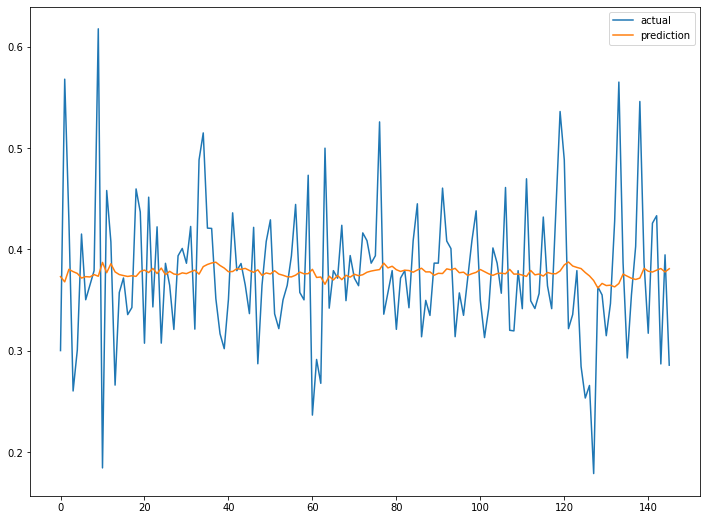

In [85]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [86]:
aa = pd.DataFrame(pred)

In [87]:
aa.columns = ['change']

In [88]:
aa['change'] = np.where(aa['change'] > 0,1,np.where(aa['change']==0,0,-1))

In [89]:
aa.change.value_counts()

1    146
Name: change, dtype: int64